# Softmax 

Text(0, 0.5, 'softmax(x)')

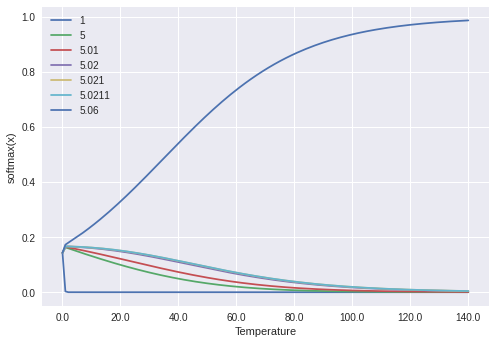

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.style.use('seaborn')

def softmax(x, t=1):
    x = np.array(x)
    return np.exp(x*t)/sum(np.exp(x*t))

x = [1, 5, 5.01, 5.02, 5.021, 5.0211, 5.06]

N = 140
t = np.linspace(-0, N, N+1)


labels = [str(xi) for xi in x]
x_ticks = [str(np.round(ti)) for ti in t]

y_sfmx = []
for ti in t:
    y_sfmx.append(softmax(x, ti))
    
y_df = pd.DataFrame(y_sfmx, columns=labels, index=x_ticks)
ax = y_df.plot()
ax.set_xlabel('Temperature')
ax.set_ylabel('softmax(x)')

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable

import os
import numpy as np
import torch
import shutil
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.autograd import Variable

from pdb import set_trace

import time

import hiddenlayer as hl


# Utils

In [ ]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt


def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res


class Cutout(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img

def _data_transforms_mnist(args):

  train_transform = transforms.Compose([
    transforms.ToTensor(),
  ])

  valid_transform = transforms.Compose([
    transforms.ToTensor(),
    ])
  return train_transform, valid_transform

def _data_transforms_cifar10(args):
  CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
  CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

  train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
  ])
  if args.cutout:
    train_transform.transforms.append(Cutout(args.cutout_length))

  valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])
  return train_transform, valid_transform


def count_parameters_in_MB(model):
  return np.sum(np.prod(v.size()) for name, v in model.named_parameters() if "auxiliary" not in name)/1e6


def save_checkpoint(state, is_best, save):
  filename = os.path.join(save, 'checkpoint.pth.tar')
  torch.save(state, filename)
  if is_best:
    best_filename = os.path.join(save, 'model_best.pth.tar')
    shutil.copyfile(filename, best_filename)


def save(model, model_path):
  torch.save(model.state_dict(), model_path)


def load(model, model_path):
  model.load_state_dict(torch.load(model_path))


def drop_path(x, drop_prob):
  if drop_prob > 0.:
    keep_prob = 1.-drop_prob
    mask = Variable(torch.cuda.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
    x.div_(keep_prob)
    x.mul_(mask)
  return x


def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)



# Genotypes

In [ ]:
from collections import namedtuple

Genotype = namedtuple('Genotype', 'normal normal_concat reduce reduce_concat')

PRIMITIVES = [
    'none',
    'max_pool_3x3',
    'avg_pool_3x3',
    'skip_connect',
    'sep_conv_3x3',
    'sep_conv_5x5',
    'dil_conv_3x3',
    'dil_conv_5x5'
]

# NASNet = Genotype(
#   normal = [
#     ('sep_conv_5x5', 1),
#     ('sep_conv_3x3', 0),
#     ('sep_conv_5x5', 0),
#     ('sep_conv_3x3', 0),
#     ('avg_pool_3x3', 1),
#     ('skip_connect', 0),
#     ('avg_pool_3x3', 0),
#     ('avg_pool_3x3', 0),
#     ('sep_conv_3x3', 1),
#     ('skip_connect', 1),
#   ],
#   normal_concat = [2, 3, 4, 5, 6],
#   reduce = [
#     ('sep_conv_5x5', 1),
#     ('sep_conv_7x7', 0),
#     ('max_pool_3x3', 1),
#     ('sep_conv_7x7', 0),
#     ('avg_pool_3x3', 1),
#     ('sep_conv_5x5', 0),
#     ('skip_connect', 3),
#     ('avg_pool_3x3', 2),
#     ('sep_conv_3x3', 2),
#     ('max_pool_3x3', 1),
#   ],
#   reduce_concat = [4, 5, 6],
# )
    
# AmoebaNet = Genotype(
#   normal = [
#     ('avg_pool_3x3', 0),
#     ('max_pool_3x3', 1),
#     ('sep_conv_3x3', 0),
#     ('sep_conv_5x5', 2),
#     ('sep_conv_3x3', 0),
#     ('avg_pool_3x3', 3),
#     ('sep_conv_3x3', 1),
#     ('skip_connect', 1),
#     ('skip_connect', 0),
#     ('avg_pool_3x3', 1),
#     ],
#   normal_concat = [4, 5, 6],
#   reduce = [
#     ('avg_pool_3x3', 0),
#     ('sep_conv_3x3', 1),
#     ('max_pool_3x3', 0),
#     ('sep_conv_7x7', 2),
#     ('sep_conv_7x7', 0),
#     ('avg_pool_3x3', 1),
#     ('max_pool_3x3', 0),
#     ('max_pool_3x3', 1),
#     ('conv_7x1_1x7', 0),
#     ('sep_conv_3x3', 5),
#   ],
#   reduce_concat = [3, 4, 6]
# )

# DARTS_V1 = Genotype(normal=[('sep_conv_3x3', 1), ('sep_conv_3x3', 0), ('skip_connect', 0), ('sep_conv_3x3', 1), ('skip_connect', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 0), ('skip_connect', 2)], normal_concat=[2, 3, 4, 5], reduce=[('max_pool_3x3', 0), ('max_pool_3x3', 1), ('skip_connect', 2), ('max_pool_3x3', 0), ('max_pool_3x3', 0), ('skip_connect', 2), ('skip_connect', 2), ('avg_pool_3x3', 0)], reduce_concat=[2, 3, 4, 5])
# DARTS_V2 = Genotype(normal=[('sep_conv_3x3', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 1), ('skip_connect', 0), ('skip_connect', 0), ('dil_conv_3x3', 2)], normal_concat=[2, 3, 4, 5], reduce=[('max_pool_3x3', 0), ('max_pool_3x3', 1), ('skip_connect', 2), ('max_pool_3x3', 1), ('max_pool_3x3', 0), ('skip_connect', 2), ('skip_connect', 2), ('max_pool_3x3', 1)], reduce_concat=[2, 3, 4, 5])

# DARTS = DARTS_V2



# Architect

In [ ]:
def _concat(xs):
  return torch.cat([x.view(-1) for x in xs])


class Architect(object):

  def __init__(self, model, args):
    self.network_momentum = args.momentum
    self.network_weight_decay = args.weight_decay
    self.model = model
    self.optimizer = torch.optim.Adam(self.model.arch_parameters(),
        lr=args.arch_learning_rate, betas=(0.5, 0.999), weight_decay=args.arch_weight_decay)

  def _compute_unrolled_model(self, input, target, eta, network_optimizer):
    loss = self.model._loss(input, target)
    theta = _concat(self.model.parameters()).data
    try:
      moment = _concat(network_optimizer.state[v]['momentum_buffer'] for v in self.model.parameters()).mul_(self.network_momentum)
    except:
      moment = torch.zeros_like(theta)
    dtheta = _concat(torch.autograd.grad(loss, self.model.parameters())).data + self.network_weight_decay*theta
    unrolled_model = self._construct_model_from_theta(theta.sub(eta, moment+dtheta))
    return unrolled_model

  def step(self, input_train, target_train, input_valid, target_valid, eta, network_optimizer, unrolled):
    self.optimizer.zero_grad()
    if unrolled:
        self._backward_step_unrolled(input_train, target_train, input_valid, target_valid, eta, network_optimizer)
    else:
        self._backward_step(input_valid, target_valid)
    self.optimizer.step()

  def _backward_step(self, input_valid, target_valid):
    loss = self.model._loss(input_valid, target_valid)
    loss.backward()

  def _backward_step_unrolled(self, input_train, target_train, input_valid, target_valid, eta, network_optimizer):
    unrolled_model = self._compute_unrolled_model(input_train, target_train, eta, network_optimizer)
    unrolled_loss = unrolled_model._loss(input_valid, target_valid)

    unrolled_loss.backward()
    dalpha = [v.grad for v in unrolled_model.arch_parameters()]
    vector = [v.grad.data for v in unrolled_model.parameters()]
    implicit_grads = self._hessian_vector_product(vector, input_train, target_train)

    for g, ig in zip(dalpha, implicit_grads):
      g.data.sub_(eta, ig.data)

    for v, g in zip(self.model.arch_parameters(), dalpha):
      if v.grad is None:
        v.grad = Variable(g.data)
      else:
        v.grad.data.copy_(g.data)

  def _construct_model_from_theta(self, theta):
    model_new = self.model.new()
    model_dict = self.model.state_dict()

    params, offset = {}, 0
    for k, v in self.model.named_parameters():
      v_length = np.prod(v.size())
      params[k] = theta[offset: offset+v_length].view(v.size())
      offset += v_length

    assert offset == len(theta)
    model_dict.update(params)
    model_new.load_state_dict(model_dict)
    return model_new.cuda()

  def _hessian_vector_product(self, vector, input, target, r=1e-2):
    R = r / _concat(vector).norm()
    for p, v in zip(self.model.parameters(), vector):
      p.data.add_(R, v)
    loss = self.model._loss(input, target)
    grads_p = torch.autograd.grad(loss, self.model.arch_parameters())

    for p, v in zip(self.model.parameters(), vector):
      p.data.sub_(2*R, v)
    loss = self.model._loss(input, target)
    grads_n = torch.autograd.grad(loss, self.model.arch_parameters())

    for p, v in zip(self.model.parameters(), vector):
      p.data.add_(R, v)

    return [(x-y).div_(2*R) for x, y in zip(grads_p, grads_n)]



# Operations

In [ ]:
import torch
import torch.nn as nn

OPS = {
  'none' : lambda C, stride, affine: Zero(stride),
  'avg_pool_3x3' : lambda C, stride, affine: nn.AvgPool2d(3, stride=stride, padding=1, count_include_pad=False),
  'max_pool_3x3' : lambda C, stride, affine: nn.MaxPool2d(3, stride=stride, padding=1),
  'skip_connect' : lambda C, stride, affine: Identity() if stride == 1 else FactorizedReduce(C, C, affine=affine),
  'sep_conv_3x3' : lambda C, stride, affine: SepConv(C, C, 3, stride, 1, affine=affine),
  'sep_conv_5x5' : lambda C, stride, affine: SepConv(C, C, 5, stride, 2, affine=affine),
  'sep_conv_7x7' : lambda C, stride, affine: SepConv(C, C, 7, stride, 3, affine=affine),
  'dil_conv_3x3' : lambda C, stride, affine: DilConv(C, C, 3, stride, 2, 2, affine=affine),
  'dil_conv_5x5' : lambda C, stride, affine: DilConv(C, C, 5, stride, 4, 2, affine=affine),
  'conv_7x1_1x7' : lambda C, stride, affine: nn.Sequential(
    nn.ReLU(inplace=False),
    nn.Conv2d(C, C, (1,7), stride=(1, stride), padding=(0, 3), bias=False),
    nn.Conv2d(C, C, (7,1), stride=(stride, 1), padding=(3, 0), bias=False),
    nn.BatchNorm2d(C, affine=affine)
    ),
}

class ReLUConvBN(nn.Module):

  def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
    super(ReLUConvBN, self).__init__()
    self.op = nn.Sequential(
      nn.ReLU(inplace=False),
      nn.Conv2d(C_in, C_out, kernel_size, stride=stride, padding=padding, bias=False),
      nn.BatchNorm2d(C_out, affine=affine)
    )

  def forward(self, x):
    return self.op(x)

class DilConv(nn.Module):
    
  def __init__(self, C_in, C_out, kernel_size, stride, padding, dilation, affine=True):
    super(DilConv, self).__init__()
    self.op = nn.Sequential(
      nn.ReLU(inplace=False),
      nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=C_in, bias=False),
      nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False),
      nn.BatchNorm2d(C_out, affine=affine),
      )

  def forward(self, x):
    return self.op(x)


class SepConv(nn.Module):
    
  def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
    super(SepConv, self).__init__()
    self.op = nn.Sequential(
      nn.ReLU(inplace=False),
      nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, padding=padding, groups=C_in, bias=False),
      nn.Conv2d(C_in, C_in, kernel_size=1, padding=0, bias=False),
      nn.BatchNorm2d(C_in, affine=affine),
      nn.ReLU(inplace=False),
      nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=1, padding=padding, groups=C_in, bias=False),
      nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False),
      nn.BatchNorm2d(C_out, affine=affine),
      )

  def forward(self, x):
    return self.op(x)


class Identity(nn.Module):

  def __init__(self):
    super(Identity, self).__init__()

  def forward(self, x):
    return x


class Zero(nn.Module):

  def __init__(self, stride):
    super(Zero, self).__init__()
    self.stride = stride

  def forward(self, x):
    if self.stride == 1:
      return x.mul(0.)
    return x[:,:,::self.stride,::self.stride].mul(0.)


class FactorizedReduce(nn.Module):

  def __init__(self, C_in, C_out, affine=True):
    super(FactorizedReduce, self).__init__()
    assert C_out % 2 == 0
    self.relu = nn.ReLU(inplace=False)
    self.conv_1 = nn.Conv2d(C_in, C_out // 2, 1, stride=2, padding=0, bias=False)
    self.conv_2 = nn.Conv2d(C_in, C_out // 2, 1, stride=2, padding=0, bias=False) 
    self.bn = nn.BatchNorm2d(C_out, affine=affine)

  def forward(self, x):
    x = self.relu(x)
    # set_trace()
    # out = torch.cat([self.conv_1(x), self.conv_2(x[:,:,1:,1:])], dim=1)
    out = torch.cat([self.conv_1(x), self.conv_2(x)], dim=1)
    out = self.bn(out)
    return out



# Model Search

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class MixedOp(nn.Module):

  def __init__(self, C, stride):
    super(MixedOp, self).__init__()
    self._ops = nn.ModuleList()
    for primitive in PRIMITIVES:
      op = OPS[primitive](C, stride, False)
      if 'pool' in primitive:
        op = nn.Sequential(op, nn.BatchNorm2d(C, affine=False))
      self._ops.append(op)

  def forward(self, x, weights):
    return sum(w * op(x) for w, op in zip(weights, self._ops))


class Cell(nn.Module):

  def __init__(self, steps, multiplier, C_prev_prev, C_prev, C, reduction, reduction_prev):
    super(Cell, self).__init__()
    self.reduction = reduction

    if reduction_prev:
      self.preprocess0 = FactorizedReduce(C_prev_prev, C, affine=False)
    else:
      self.preprocess0 = ReLUConvBN(C_prev_prev, C, 1, 1, 0, affine=False)
    self.preprocess1 = ReLUConvBN(C_prev, C, 1, 1, 0, affine=False)
    self._steps = steps
    self._multiplier = multiplier

    self._ops = nn.ModuleList()
    self._bns = nn.ModuleList()
    for i in range(self._steps):
      for j in range(2+i):
        stride = 2 if reduction and j < 2 else 1
        op = MixedOp(C, stride)
        self._ops.append(op)

  def forward(self, s0, s1, weights):
    s0 = self.preprocess0(s0)
    s1 = self.preprocess1(s1)

    states = [s0, s1]
    offset = 0
    for i in range(self._steps):
      s = sum(self._ops[offset+j](h, weights[offset+j]) for j, h in enumerate(states))
      offset += len(states)
      states.append(s)

    return torch.cat(states[-self._multiplier:], dim=1)


class Network(nn.Module):

  def __init__(self, C, num_classes, layers, criterion, steps=4, multiplier=4, stem_multiplier=3):
    super(Network, self).__init__()
    self._C = C
    self._num_classes = num_classes
    self._layers = layers
    self._criterion = criterion
    self._steps = steps
    self._multiplier = multiplier

    C_curr = stem_multiplier*C
    self.stem = nn.Sequential(
      nn.Conv2d(1, C_curr, 3, padding=1, bias=False), # MNIST
      # nn.Conv2d(3, C_curr, 3, padding=1, bias=False), # CIFAR
      nn.BatchNorm2d(C_curr)
    )
 
    C_prev_prev, C_prev, C_curr = C_curr, C_curr, C
    self.cells = nn.ModuleList()
    reduction_prev = False
    for i in range(layers):
      if i in [layers//3, 2*layers//3]:
        C_curr *= 2
        reduction = True
      else:
        reduction = False
      cell = Cell(steps, multiplier, C_prev_prev, C_prev, C_curr, reduction, reduction_prev)
      reduction_prev = reduction
      self.cells += [cell]
      C_prev_prev, C_prev = C_prev, multiplier*C_curr

    self.global_pooling = nn.AdaptiveAvgPool2d(1)
    self.classifier = nn.Linear(C_prev, num_classes)

    self._initialize_alphas()

  def new(self):
    model_new = Network(self._C, self._num_classes, self._layers, self._criterion).cuda()
    for x, y in zip(model_new.arch_parameters(), self.arch_parameters()):
        x.data.copy_(y.data)
    return model_new

  def forward(self, input):
    # set_trace()
    s0 = s1 = self.stem(input)
    for i, cell in enumerate(self.cells):
      if cell.reduction:
        weights = F.softmax(self.alphas_reduce, dim=-1)
      else:
        weights = F.softmax(self.alphas_normal, dim=-1)
      s0, s1 = s1, cell(s0, s1, weights)
    out = self.global_pooling(s1)
    logits = self.classifier(out.view(out.size(0),-1))
    return logits

  def _loss(self, input, target):
    logits = self(input)
    return self._criterion(logits, target) 

  def _initialize_alphas(self):
    k = sum(1 for i in range(self._steps) for n in range(2+i))
    num_ops = len(PRIMITIVES)

    self.alphas_normal = Variable(1e-3*torch.randn(k, num_ops).cuda(), requires_grad=True)
    self.alphas_reduce = Variable(1e-3*torch.randn(k, num_ops).cuda(), requires_grad=True)
    self._arch_parameters = [
      self.alphas_normal,
      self.alphas_reduce,
    ]

  def arch_parameters(self):
    return self._arch_parameters

  def genotype(self):

    def _parse(weights):
      gene = []
      n = 2
      start = 0
      for i in range(self._steps):
        end = start + n
        W = weights[start:end].copy()
        edges = sorted(range(i + 2), key=lambda x: -max(W[x][k] for k in range(len(W[x])) if k != PRIMITIVES.index('none')))[:2]
        for j in edges:
          k_best = None
          for k in range(len(W[j])):
            if k != PRIMITIVES.index('none'):
              if k_best is None or W[j][k] > W[j][k_best]:
                k_best = k
          gene.append((PRIMITIVES[k_best], j))
        start = end
        n += 1
      return gene

    gene_normal = _parse(F.softmax(self.alphas_normal, dim=-1).data.cpu().numpy())
    gene_reduce = _parse(F.softmax(self.alphas_reduce, dim=-1).data.cpu().numpy())

    concat = range(2+self._steps-self._multiplier, self._steps+2)
    genotype = Genotype(
      normal=gene_normal, normal_concat=concat,
      reduce=gene_reduce, reduce_concat=concat
    )
    return genotype



# Train Search

In [ ]:
class Args():

  data = '../data'
  batch_size = 64
  learning_rate = 0.025
  learning_rate_min = 0.001
  momentum = 0.9
  weight_decay = 3e-4
  report_freq = 20
  gpu = 1
  epochs = 5
  init_channels = 16
  layers = 2
  model_path = 'saved_models'
  cutout = False
  cutout_length = 16
  drop_path_prob = 0.3
  save = 'EXP'
  seed = 2
  grad_clip = 5
  train_portion = 0.5
  unrolled = False
  arch_learning_rate = 3e-4
  arch_weight_decay = 1e-3

args = Args()

08/17 10:20:09 PM Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/17 10:20:09 PM Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/17 10:20:09 PM Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
08/17 10:20:09 PM Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


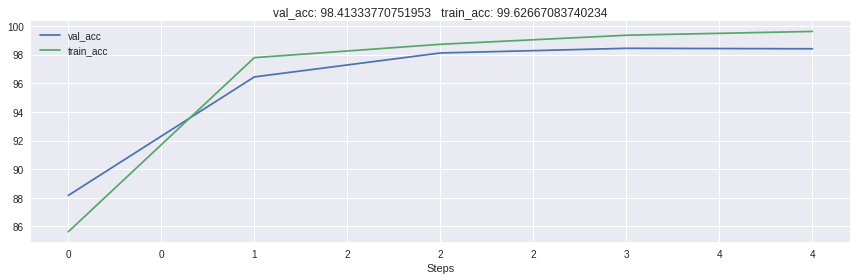

In [ ]:
import os
import sys
import time
import glob
import numpy as np
import torch
import logging
import argparse
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import matplotlib as mpl
mpl.style.use('seaborn')

from torch.autograd import Variable

args.save = 'search-{}-{}'.format(args.save, time.strftime("%Y%m%d-%H%M%S"))
create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))

log_format = '%(asctime)s %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
    format=log_format, datefmt='%m/%d %I:%M:%S %p')
fh = logging.FileHandler(os.path.join(args.save, 'log.txt'))
fh.setFormatter(logging.Formatter(log_format))
logging.getLogger().addHandler(fh)


CIFAR_CLASSES = 10


def main():
  if not torch.cuda.is_available():
    logging.info('no gpu device available')
    sys.exit(1)

  np.random.seed(args.seed)

  # device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  # device = torch.device('cuda:0')
  # torch.cuda.set_device(device)
  # torch.cuda.set_device("cpu")
  # torch.cuda.set_device("cuda:0")

  cudnn.benchmark = True
  torch.manual_seed(args.seed)
  cudnn.enabled=True
  torch.cuda.manual_seed(args.seed)
  logging.info('gpu device = %d' % args.gpu)
  logging.info("args = %s", args)

  criterion = nn.CrossEntropyLoss()
  criterion = criterion.cuda()
  model = Network(args.init_channels, CIFAR_CLASSES, args.layers, criterion)
  model = model.cuda()
  logging.info("param size = %fMB", count_parameters_in_MB(model))

  optimizer = torch.optim.SGD(
      model.parameters(),
      args.learning_rate,
      momentum=args.momentum,
      weight_decay=args.weight_decay)

  # train_transform, valid_transform = _data_transforms_cifar10(args)
  # train_data = dset.CIFAR10(root=args.data, train=True, download=True, transform=train_transform)
  
  train_transform, valid_transform = _data_transforms_mnist(args)
  train_data = dset.MNIST(root=args.data, train=True, download=True, transform=train_transform)

  part_of_data = 0.5
  num_train =  int(len(train_data) * part_of_data)
  indices = list(range(num_train))
  split = int(np.floor(args.train_portion * num_train))

  train_queue = torch.utils.data.DataLoader(
      train_data, batch_size=args.batch_size,
      sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
      pin_memory=True, num_workers=2)

  valid_queue = torch.utils.data.DataLoader(
      train_data, batch_size=args.batch_size,
      sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
      pin_memory=True, num_workers=2)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, float(args.epochs), eta_min=args.learning_rate_min)

  architect = Architect(model, args)

  
  # A History object to store metrics
  history1 = hl.History()

  # A Canvas object to draw the metrics
  canvas1 = hl.Canvas()

  for epoch in range(args.epochs):
    scheduler.step()
    lr = scheduler.get_lr()[0]
    logging.info('epoch %d lr %e', epoch, lr)

    genotype = model.genotype()
    logging.info('genotype = %s', genotype)

    print(F.softmax(model.alphas_normal, dim=-1))
    print(F.softmax(model.alphas_reduce, dim=-1))

    # training
    train_acc, train_obj = train(train_queue, valid_queue, model, architect, criterion, optimizer, lr)
    logging.info('train_acc %f', train_acc)

    # validation
    valid_acc, valid_obj = infer(valid_queue, model, criterion)
    logging.info('valid_acc %f', valid_acc)

        # Store metrics in the history object
    history1.log(epoch, val_acc=valid_acc, train_acc=train_acc)

    # Plot the two metrics in one graph
    canvas1.draw_plot([history1["val_acc"], history1["train_acc"]])

    save(model, os.path.join(args.save, 'weights.pt'))
    


def train(train_queue, valid_queue, model, architect, criterion, optimizer, lr):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()

  t0 = time.time();

    
  # A History object to store metrics
  history2 = hl.History()

  # A Canvas object to draw the metrics
  canvas2 = hl.Canvas()
  canvas3 = hl.Canvas()

  for step, (input, target) in enumerate(train_queue):
    model.train()
    n = input.size(0)

    input = Variable(input, requires_grad=False).cuda()
    target = Variable(target, requires_grad=False).cuda(async=True)

    # get a random minibatch from the search queue with replacement
    input_search, target_search = next(iter(valid_queue))
    input_search = Variable(input_search, requires_grad=False).cuda()
    target_search = Variable(target_search, requires_grad=False).cuda(async=True)

    architect.step(input, target, input_search, target_search, lr, optimizer, unrolled=args.unrolled)

    optimizer.zero_grad()
    logits = model(input)
    loss = criterion(logits, target)

    loss.backward()
    nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.data, n)
    top1.update(prec1.data, n)
    top5.update(prec5.data, n)


    # Store metrics in the history object
    history2.log(step, loss=loss.data, accuracy=prec1)

    if step % args.report_freq == 0:

      # Plot the two metrics in one graph
      with canvas2:
        canvas2.draw_plot([history2["loss"]])
        canvas2.draw_plot([history2["accuracy"]])

      t1 = time.time();
      dt = t1 - t0;
      t0 = t1;
      logging.info('train %03d %e %f %f --- %f sec', step, objs.avg, top1.avg, top5.avg, dt)

  return top1.avg, objs.avg


def infer(valid_queue, model, criterion):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  model.eval()

  for step, (input, target) in enumerate(valid_queue):
    input = Variable(input, volatile=True).cuda()
    target = Variable(target, volatile=True).cuda(async=True)

    logits = model(input)
    loss = criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.data, n)
    top1.update(prec1.data, n)
    top5.update(prec5.data, n)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg


if __name__ == '__main__':
  main() 



# Model

In [ ]:
PATH = '/content/search-EXP-20200817-210947/weights.pt'
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
model = Network(args.init_channels, CIFAR_CLASSES, args.layers, criterion)
model.load_state_dict(torch.load(PATH))
model.eval()

DARTS = model.genotype()
list(DARTS)

[[('max_pool_3x3', 0),
  ('avg_pool_3x3', 1),
  ('sep_conv_5x5', 2),
  ('max_pool_3x3', 0),
  ('skip_connect', 3),
  ('max_pool_3x3', 2),
  ('sep_conv_5x5', 4),
  ('dil_conv_3x3', 2)],
 range(2, 6),
 [('avg_pool_3x3', 1),
  ('avg_pool_3x3', 0),
  ('skip_connect', 0),
  ('dil_conv_5x5', 2),
  ('sep_conv_5x5', 3),
  ('skip_connect', 2),
  ('sep_conv_5x5', 3),
  ('dil_conv_3x3', 1)],
 range(2, 6)]

In [ ]:
class Cell(nn.Module):

  def __init__(self, genotype, C_prev_prev, C_prev, C, reduction, reduction_prev):
    super(Cell, self).__init__()
    print(C_prev_prev, C_prev, C)

    if reduction_prev:
      self.preprocess0 = FactorizedReduce(C_prev_prev, C)
    else:
      self.preprocess0 = ReLUConvBN(C_prev_prev, C, 1, 1, 0)
    self.preprocess1 = ReLUConvBN(C_prev, C, 1, 1, 0)
    
    if reduction:
      op_names, indices = zip(*genotype.reduce)
      concat = genotype.reduce_concat
    else:
      op_names, indices = zip(*genotype.normal)
      concat = genotype.normal_concat
    self._compile(C, op_names, indices, concat, reduction)

  def _compile(self, C, op_names, indices, concat, reduction):
    assert len(op_names) == len(indices)
    self._steps = len(op_names) // 2
    self._concat = concat
    self.multiplier = len(concat)

    self._ops = nn.ModuleList()
    for name, index in zip(op_names, indices):
      stride = 2 if reduction and index < 2 else 1
      op = OPS[name](C, stride, True)
      self._ops += [op]
    self._indices = indices

  def forward(self, s0, s1, drop_prob):
    s0 = self.preprocess0(s0)
    s1 = self.preprocess1(s1)

    states = [s0, s1]
    for i in range(self._steps):
      h1 = states[self._indices[2*i]]
      h2 = states[self._indices[2*i+1]]
      op1 = self._ops[2*i]
      op2 = self._ops[2*i+1]
      h1 = op1(h1)
      h2 = op2(h2)
      if self.training and drop_prob > 0.:
        if not isinstance(op1, Identity):
          h1 = drop_path(h1, drop_prob)
        if not isinstance(op2, Identity):
          h2 = drop_path(h2, drop_prob)
      s = h1 + h2
      states += [s]
    return torch.cat([states[i] for i in self._concat], dim=1)


# class AuxiliaryHeadCIFAR(nn.Module):

#   def __init__(self, C, num_classes):
#     """assuming input size 8x8"""
#     super(AuxiliaryHeadCIFAR, self).__init__()
#     self.features = nn.Sequential(
#       nn.ReLU(inplace=True),
#       nn.AvgPool2d(5, stride=3, padding=0, count_include_pad=False), # image size = 2 x 2
#       nn.Conv2d(C, 128, 1, bias=False),
#       nn.BatchNorm2d(128),
#       nn.ReLU(inplace=True),
#       nn.Conv2d(128, 768, 2, bias=False),
#       nn.BatchNorm2d(768),
#       nn.ReLU(inplace=True)
#     )
#     self.classifier = nn.Linear(768, num_classes)

#   def forward(self, x):
#     x = self.features(x)
#     x = self.classifier(x.view(x.size(0),-1))
#     return x


# class AuxiliaryHeadImageNet(nn.Module):

#   def __init__(self, C, num_classes):
#     """assuming input size 14x14"""
#     super(AuxiliaryHeadImageNet, self).__init__()
#     self.features = nn.Sequential(
#       nn.ReLU(inplace=True),
#       nn.AvgPool2d(5, stride=2, padding=0, count_include_pad=False),
#       nn.Conv2d(C, 128, 1, bias=False),
#       nn.BatchNorm2d(128),
#       nn.ReLU(inplace=True),
#       nn.Conv2d(128, 768, 2, bias=False),
#       # NOTE: This batchnorm was omitted in my earlier implementation due to a typo.
#       # Commenting it out for consistency with the experiments in the paper.
#       # nn.BatchNorm2d(768),
#       nn.ReLU(inplace=True)
#     )
#     self.classifier = nn.Linear(768, num_classes)

#   def forward(self, x):
#     x = self.features(x)
#     x = self.classifier(x.view(x.size(0),-1))
#     return x

class MyNetwork(nn.Module):
  def __init__(self, C, num_classes, layers, auxiliary, genotype):
    super(MyNetwork, self).__init__()

  def forward(self, x):
    return x

class NetworkCIFAR(nn.Module):

  def __init__(self, C, num_classes, layers, auxiliary, genotype):
    super(NetworkCIFAR, self).__init__()
    self._layers = layers
    self._auxiliary = auxiliary
    self.drop_path_prob = 0.2
    

    stem_multiplier = 3
    C_curr = stem_multiplier*C
    self.stem = nn.Sequential(
      nn.Conv2d(1, C_curr, 3, padding=1, bias=False), # MNIST
      # nn.Conv2d(3, C_curr, 3, padding=1, bias=False), # CIFAR
      nn.BatchNorm2d(C_curr)
    )
    
    C_prev_prev, C_prev, C_curr = C_curr, C_curr, C
    self.cells = nn.ModuleList()
    reduction_prev = False
    for i in range(layers):
      if i in [layers//3, 2*layers//3]:
        C_curr *= 2
        reduction = True
      else:
        reduction = False
      cell = Cell(genotype, C_prev_prev, C_prev, C_curr, reduction, reduction_prev)
      reduction_prev = reduction
      self.cells += [cell]
      C_prev_prev, C_prev = C_prev, cell.multiplier*C_curr
      if i == 2*layers//3:
        C_to_auxiliary = C_prev

    if auxiliary:
      self.auxiliary_head = AuxiliaryHeadCIFAR(C_to_auxiliary, num_classes)
    self.global_pooling = nn.AdaptiveAvgPool2d(1)
    self.classifier = nn.Linear(C_prev, num_classes)

  def forward(self, input):
    logits_aux = None
    s0 = s1 = self.stem(input)
    for i, cell in enumerate(self.cells):
      s0, s1 = s1, cell(s0, s1, self.drop_path_prob)
      # s0, s1 = s1, cell(s0, s1)
      if i == 2*self._layers//3:
        if self._auxiliary and self.training:
          logits_aux = self.auxiliary_head(s1)
    out = self.global_pooling(s1)
    logits = self.classifier(out.view(out.size(0),-1))
    return logits, logits_aux


# class NetworkImageNet(nn.Module):

#   def __init__(self, C, num_classes, layers, auxiliary, genotype):
#     super(NetworkImageNet, self).__init__()
#     self._layers = layers
#     self._auxiliary = auxiliary

#     self.stem0 = nn.Sequential(
#       nn.Conv2d(3, C // 2, kernel_size=3, stride=2, padding=1, bias=False),
#       nn.BatchNorm2d(C // 2),
#       nn.ReLU(inplace=True),
#       nn.Conv2d(C // 2, C, 3, stride=2, padding=1, bias=False),
#       nn.BatchNorm2d(C),
#     )

#     self.stem1 = nn.Sequential(
#       nn.ReLU(inplace=True),
#       nn.Conv2d(C, C, 3, stride=2, padding=1, bias=False),
#       nn.BatchNorm2d(C),
#     )

#     C_prev_prev, C_prev, C_curr = C, C, C

#     self.cells = nn.ModuleList()
#     reduction_prev = True
#     for i in range(layers):
#       if i in [layers // 3, 2 * layers // 3]:
#         C_curr *= 2
#         reduction = True
#       else:
#         reduction = False
#       cell = Cell(genotype, C_prev_prev, C_prev, C_curr, reduction, reduction_prev)
#       reduction_prev = reduction
#       self.cells += [cell]
#       C_prev_prev, C_prev = C_prev, cell.multiplier * C_curr
#       if i == 2 * layers // 3:
#         C_to_auxiliary = C_prev

#     if auxiliary:
#       self.auxiliary_head = AuxiliaryHeadImageNet(C_to_auxiliary, num_classes)
#     self.global_pooling = nn.AvgPool2d(7)
#     self.classifier = nn.Linear(C_prev, num_classes)

#   def forward(self, input):
#     logits_aux = None
#     s0 = self.stem0(input)
#     s1 = self.stem1(s0)
#     for i, cell in enumerate(self.cells):
#       s0, s1 = s1, cell(s0, s1, self.drop_path_prob)
#       if i == 2 * self._layers // 3:
#         if self._auxiliary and self.training:
#           logits_aux = self.auxiliary_head(s1)
#     out = self.global_pooling(s1)
#     logits = self.classifier(out.view(out.size(0), -1))
#     return logits, logits_aux



In [ ]:
! pip install torchviz

     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=d24a78e4520f96625306752b8f63e92a8c573f373257cb9db4e00103faa66d0b
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


# Train

In [ ]:
class Args():

    data = '../data'
    batch_size = 96
    learning_rate = 0.025
    momentum = 0.9
    weight_decay = 3e-4
    report_freq = 50
    gpu = 0
    epochs = 300
    init_channels = 36
    layers = 20
    model_path = 'saved_models'
    auxiliary = False
    auxiliary_weight = 0.4
    cutout = False
    cutout_length = 16
    drop_path_prob = 0.2
    save = 'EXP'
    seed = 0
    arch = 'DARTS'
    grad_clip = 5

args = Args()

108 108 36
108 144 36
144 144 36
144 144 36
144 144 36
144 144 36
144 144 72
144 288 72
288 288 72
288 288 72
288 288 72
288 288 72
288 288 72
288 288 144
288 576 144
576 576 144
576 576 144
576 576 144
576 576 144
576 576 144


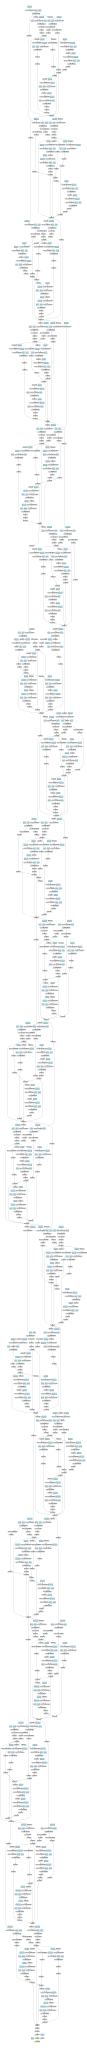

In [ ]:
from torchviz import make_dot, make_dot_from_trace
x = Variable(torch.randn(108, 1, 3, 3))

NetworkApply = NetworkCIFAR

genotype = DARTS
model = NetworkApply(args.init_channels, CIFAR_CLASSES, args.layers, args.auxiliary, genotype)
model.to('cuda:0')
# make_dot(model(x.cuda())[0], params=dict(list(model.named_parameters())))
make_dot(model(x.cuda())[0])


In [ ]:
import os
import sys
import time
import glob
import numpy as np
import torch
import logging
import argparse
import torch.nn as nn
import torch.utils
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
NetworkApply = NetworkCIFAR

from IPython.core.debugger import set_trace




args.save = 'eval-{}-{}'.format(args.save, time.strftime("%Y%m%d-%H%M%S"))
create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))

log_format = '%(asctime)s %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
    format=log_format, datefmt='%m/%d %I:%M:%S %p')
fh = logging.FileHandler(os.path.join(args.save, 'log.txt'))
fh.setFormatter(logging.Formatter(log_format))
logging.getLogger().addHandler(fh)

CIFAR_CLASSES = 10


def main():
  if not torch.cuda.is_available():
    logging.info('no gpu device available')
    raise RuntimeError("no gpu device available")
    # sys.exit(1)

  np.random.seed(args.seed)
  torch.cuda.set_device("cuda:0")
  cudnn.benchmark = True
  torch.manual_seed(args.seed)
  cudnn.enabled=True
  torch.cuda.manual_seed(args.seed)
  logging.info('gpu device = %d' % args.gpu)
  logging.info("args = %s", args)

  genotype = eval("%s" % args.arch)
  model = NetworkApply(args.init_channels, CIFAR_CLASSES, args.layers, args.auxiliary, genotype)
  model = model.cuda()

  
  # hl.build_graph(model, input)

  logging.info("param size = %fMB", count_parameters_in_MB(model))

  criterion = nn.CrossEntropyLoss()
  criterion = criterion.cuda()
  optimizer = torch.optim.SGD(
      model.parameters(),
      args.learning_rate,
      momentum=args.momentum,
      weight_decay=args.weight_decay
      )

  train_transform, valid_transform = _data_transforms_cifar10(args)
  train_data = dset.CIFAR10(root=args.data, train=True, download=True, transform=train_transform)
  valid_data = dset.CIFAR10(root=args.data, train=False, download=True, transform=valid_transform)

  train_queue = torch.utils.data.DataLoader(
      train_data, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=2)

  valid_queue = torch.utils.data.DataLoader(
      valid_data, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=2)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, float(args.epochs))

  # set_trace()
  # hl.build_graph(model, torch.zeros([96, 3, 32, 32]).cuda())
  # sys.exit()
  # sys.exit()
  
  for epoch in range(args.epochs):
    scheduler.step()
    logging.info('epoch %d lr %e', epoch, scheduler.get_lr()[0])
    model.drop_path_prob = args.drop_path_prob * epoch / args.epochs

    train_acc, train_obj = train(train_queue, model, criterion, optimizer)
    logging.info('train_acc %f', train_acc)

    valid_acc, valid_obj = infer(valid_queue, model, criterion)
    logging.info('valid_acc %f', valid_acc)

    save(model, os.path.join(args.save, 'weights.pt'))


def train(train_queue, model, criterion, optimizer):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  model.train()



  for step, (data_in, data_target) in enumerate(train_queue):
    input = Variable(data_in).cuda()
    target = Variable(data_target).cuda(async=True)



    optimizer.zero_grad()
    logits, logits_aux = model(input)
    loss = criterion(logits, target)
    if args.auxiliary:
      loss_aux = criterion(logits_aux, target)
      loss += args.auxiliary_weight*loss_aux
    loss.backward()
    nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    
    # set_trace()

    input_dim0 = input.size(0)
    # n = input.size(0)
    

    objs.update(loss.data, input_dim0)
    top1.update(prec1.data, input_dim0)
    top5.update(prec5.data, input_dim0)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

    del input, target, logits, logits_aux, loss
    

  return top1.avg, objs.avg


def infer(valid_queue, model, criterion):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  model.eval()

  for step, (data_input, data_target) in enumerate(valid_queue):
    print('------------', step)
    input = Variable(data_input, volatile=True).cuda()
    target = Variable(data_target, volatile=True).cuda(async=True)

    logits, _ = model(input)
    loss = criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    
    input_dim0 = input.size(0)   


    
    objs.update(loss.data, input_dim0)
    top1.update(prec1.data, input_dim0)
    top5.update(prec5.data, input_dim0)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

    del loss
    del logits
    del input
    del target

  return top1.avg, objs.avg


if __name__ == '__main__':
  # with LineProfiler(main, train, infer) as prof:    
    main() 
  # prof.display()



Experiment dir : eval-EXP-20200817-182235
08/17 06:22:35 PM gpu device = 0
08/17 06:22:35 PM args = <__main__.Args object at 0x7fd700e569b0>
108 108 36
108 144 36
144 144 36
144 144 36
144 144 36
144 144 36
144 144 72
144 288 72
288 288 72
288 288 72
288 288 72
288 288 72
288 288 72
288 288 144
288 576 144
576 576 144
576 576 144
576 576 144
576 576 144
576 576 144
08/17 06:22:36 PM param size = 2.808262MB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


Files already downloaded and verified
Files already downloaded and verified
08/17 06:22:37 PM epoch 0 lr 2.499863e-02


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


RuntimeError: ignored

In [ ]:
prof.display()

In [ ]:
! pip install hiddenlayer

In [ ]:
import hiddenlayer as hl

# model = Network(args.init_channels, CIFAR_CLASSES, args.layers, args.auxiliary, genotype)
hl.build_graph(model, input)